# Input files for MITgcm runs
Generates the input files in binary format for MITgcm simmulations of the front observed by SODA deployment 2.

In [1]:
# load packages
from scipy import signal, interpolate, integrate
from scipy.optimize import curve_fit, fsolve
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import gsw
import os
from copy import copy
import mdjwf

# files and paths
datapath = '/home/Marion.Alberty/projects/Arctic/front_SODA_lowres/data/'
datain = datapath + 'deployment2.mat'
# output file type
tp = '>f8'

## Model grid
Model domain and resolution are set by the variables $L(x,y,z)$ and $N(x,y,z)$, respectively. Both are dictionaries and the integer values can be easily changed to adjust the model grid and domain. Domain ($L$) units are given in *km, km, m*. The along-front direction is $x$, across-front is $y$, and vertical is $z$. Grid spacing is uniform in the along-front direction and non-uniform in the across-front and vertical.

In [2]:
# Set domain and resolution
L = {'x': 1, 'y': 30, 'z': 150}
N = {'x': 1, 'y': 50, 'z': 25}

# Calculate x grid
x = {'G':np.linspace(0,L['x'],N['x']+1)}
# At the grid centers
x['C'] = x['G'][0:-1] + np.diff(x['G'])/2

## Read in deployment data

In [3]:
# read in data file
ds = sio.loadmat(datain)
# Flatten 1-D variables
ds['y'] = ds['y'].flatten()
ds['z'] = ds['z'].flatten()
ds['p'] = ds['p'].flatten()
ds['lat'] = ds['lat'].flatten()
ds['lon'] = ds['lon'].flatten()

## Determine background profile

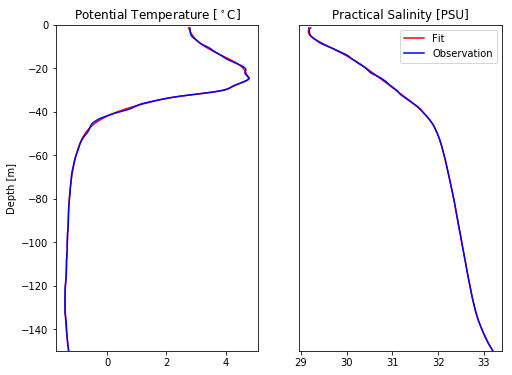

In [4]:
# Average over first half of data
ind = round(ds['y'].size/2)-1
# Make window for smoothing
b = signal.windows.hann(11)
# Get mean PT
ds['PT_bar'] = signal.filtfilt(b,b.sum(),np.mean(ds['PT'], axis=1))
# Get mean SP
ds['S_bar'] = signal.filtfilt(b,b.sum(),np.mean(ds['S'], axis=1))

# Determine high order fits to temperature and salinity profiles for easy scaling
# Temperature, sum of gaussians
def T_func(x,a1,b1,c1,a2,b2,c2,a3,b3,c3,a4,b4,c4,a5,b5,c5,a6,b6,c6):
    return a1*np.exp(-((x-b1)/c1)**2) + a2*np.exp(-((x-b2)/c2)**2) + \
            a3*np.exp(-((x-b3)/c3)**2) + a4*np.exp(-((x-b4)/c4)**2) + \
            a5*np.exp(-((x-b5)/c5)**2) + a6*np.exp(-((x-b6)/c6)**2)
# Sallinity, sum of sin and cos
def S_func(x,a0,a1,b1,a2,b2,a3,b3,a4,b4,a5,b5,a6,b6,a7,b7,a8,b8):
    w = np.pi/(np.max(x)-np.min(x))
    return a0 + a1*np.cos(x*w) + b1*np.sin(x*w) + a2*np.cos(2*x*w) + b2*np.sin(2*x*w) + \
            a3*np.cos(3*x*w) + b3*np.sin(3*x*w) + a4*np.cos(4*x*w) + b4*np.sin(4*x*w) + \
            a5*np.cos(5*x*w) + b5*np.sin(5*x*w) + a6*np.cos(6*x*w) + b6*np.sin(6*x*w) + \
            a7*np.cos(7*x*w) + b7*np.sin(7*x*w) + a8*np.cos(8*x*w) + b8*np.sin(8*x*w)

# Estimate coefficients
popt_T, pcov_T = curve_fit(T_func, ds['z'], ds['PT_bar'])
popt_S, pcov_S = curve_fit(S_func, ds['z'], ds['S_bar'])

# plot mean profiles
plt.figure(1,figsize=(8,6))
plt.subplot(121)
plt.plot(T_func(ds['z'],*popt_T),ds['z'],'r',ds['PT_bar'],ds['z'],'b')
plt.ylabel('Depth [m]')
plt.ylim(-L['z'],0)
plt.title('Potential Temperature [$^\circ$C]')

plt.subplot(122)
plt.plot(S_func(ds['z'],*popt_S),ds['z'],'r',ds['S_bar'],ds['z'],'b')
plt.ylim(-L['z'],0)
plt.yticks([])
plt.title('Practical Salinity [PSU]')
plt.legend(('Fit','Observation'))

plt.show()

## Determine scales and parameters for front
- $L_f$: Frontal width
- $dT,dS$: Frontal temperature and salinity gradient
- $H1$: Depth of the mixed layer front
- $dh$: Thickness of the mixed layer pycnocline

In [5]:
# Frontal width
Lf = ds['y'][-1]/2

# Horizontal gradient in mixed layer
# Sort first and last profiles
ind0 = np.argsort(ds['S'][:,0])
indN = np.argsort(ds['S'][:,-1])
# First profile
S0 = ds['S'][ind0,0]
T0 = ds['PT'][ind0,0]
# Last profile
SN = ds['S'][indN,-1]
TN = ds['PT'][indN,-1]
# Calc surface gradients
dT = TN[0] - T0[0]
dS = SN[0] - S0[0]

# Get depth of shallow mixed layer
ind_sML = np.argmax(SN - SN[0] > 0.1)
h_sML = ds['z'][ind_sML]
# Get depth where vertical gradient equals horizontal
ind_bML = np.argmax(SN - SN[0] > -dS)
h_bML = ds['z'][ind_bML]

# Layer 1 thickness [m]
H1 = -(h_sML + h_bML)/2
# Thickness of mixed layer pycnocline [m]
dh = -(h_bML - h_sML)/2

## Make Y grid
The across-front spacing concentrates resolution around the front with the form: $$ \Delta y(n) = A - B \mathrm{sech} ^2(C(n+D))$$ for $n \in [0, N_y-1]$.
Coefficients are chosen to aproximate desired frontal structure.
Relax to coarse resolution near the sides: $$A = \Delta y_{max}$$
Finest resolution near the front: $$B = \Delta y_{max} - \Delta y_{min}$$ $$D = -\frac{N_y-1}{2}$$
Numerically solve for $C$, which controls the width of the tranistion around the front, such that: $$\int_{0}^{N_y-1} \Delta y(n) dn = L_y$$ This ensures that the sum of $\Delta y$ is nearly $L_y$. The following equation is solved: $$L_y = A(N_y-1) - \frac{B}{C}[\tanh(C(N_y-1+D)) - \tanh(CD)]$$

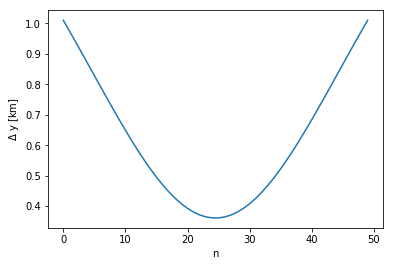

In [6]:
# Get min and max resolution
delY_min = 3*Lf/N['y']
delY_max = 3*L['y']/N['y']
# Set coefficients for delY
A = delY_max
B = delY_max - delY_min
D = -(N['y']-1)/2
# Define function
func = lambda C : A*(N['y'] - 1) - (B/C)*(np.tanh(C*(N['y'] - 1 + D)) - np.tanh(C*D)) - L['y']
# Solve for C
C_initial = -0.1 # Determined by plotting and looking for zero crossing
C = fsolve(func, C_initial)

# Solve original equation for delY
n = np.arange(0,N['y'])
delY = (A - B*(np.cosh(C*(n+D))**-2))*1000
# Calculate y from delY
# At the grid faces
y = {'G':np.append([0], np.cumsum(delY)/1000)}
# At the grid centers
y['C'] = y['G'][0:-1] + np.diff(y['G'])/2

# Plot delY
plt.plot(n,delY/1000)
plt.xlabel("n")
plt.ylabel("$\Delta$ y [km]")
plt.show()

## Make Z grid
Vertical grid spacing concentrates resolution near the surface with the form: $$ \Delta z(n) = A + \cosh(Bn)$$ for $n \in [0, N_z-1]$. Coeffients are determined to acheive fine resolution of $\Delta z_{min}$ near the surface: $$ A = \Delta z_{min} - 1$$
Numerically solve for $B$, such that $$\int_{0}^{N_z-1}\Delta z(n) = L_z$$ This ensures that the sum of $\Delta z$ is nearly $L_z$. The following equation is solved: $$L_z = A(N_z-1) + \frac{1}{B}\sinh(B(N_z-1))$$


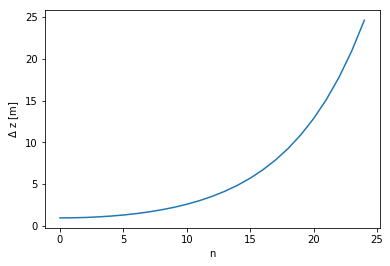

In [7]:
# Get min resolution
delZ_min = 2*H1/N['z']
# Set coefficients for delZ
A = delZ_min - 1
# Define function to solve for B
func = lambda B : A*(N['z'] - 1 ) + np.sinh(B*(N['z']-1))/B - L['z']
# Solve for B
B_initial = -0.15 # Determined by plotting and looking for zero crossing
B = fsolve(func, B_initial)

# Solve original equation for delZ
n = np.arange(0,N['z'])
delZ = A + np.cosh(B*n)
# Calculate z from delZ
# At the grid faces
z = {'G': -1*np.append([0], np.cumsum(delZ))}
# At the grid centers
z['C'] = z['G'][0:-1] + np.diff(z['G'])/2

# Plot delZ
plt.plot(n,delZ)
plt.xlabel("n")
plt.ylabel("$\Delta$ z [m]")
plt.show()

## Get approximate lat, lon for grid

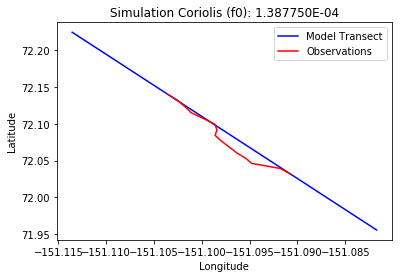

In [8]:
# Get offset for y
y_offset = L['y']/2 - ds['y'][-1]/2
# Interp/Extrap to lat, lon coordinates
f_lat = interpolate.interp1d([ds['y'][0], ds['y'][-1]] + y_offset,[ds['lat'][0], ds['lat'][-1]],\
                                   fill_value="extrapolate")
f_lon = interpolate.interp1d([ds['y'][0], ds['y'][-1]] + y_offset,[ds['lon'][0], ds['lon'][-1]],\
                                   fill_value="extrapolate")
ll = {'lat':f_lat(y['C']), 'lat_G':f_lat(y['G']), 'lon':f_lon(y['C']), 'lon_G':f_lon(y['G'])}

# Get mean lat for f
lat_4f = ll['lat'].mean()
# Get corresponding f
f = gsw.f(lat_4f)

plt.plot(ll['lon'],ll['lat'],'b',ds['lon'],ds['lat'],'r')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(('Model Transect','Observations'))
plt.title('Simulation Coriolis (f0): %.6E' %f)
plt.show()

## Calculate full Temperature and Salinity fields

The front is assumed to have the form $$b(y,z) = \frac{\Delta B}{4} \tanh(\frac{z+H1}{dh}+1) \tanh(\frac{y-\frac{L_y}{2}}{L_f}+1)$$

In [9]:
# Define function that approximates mixed layer front
def MLfront(z,y,L,L_f,dh,H,dB):
    # Calculates 2-D surface mixed layer front
    y, z = np.meshgrid(y,z)
    return (dB/4)*(np.tanh((z+H)/dh)+1)*(np.tanh((y-(L/2))/L_f)+1)

In [10]:
# Make model fields that are uniform laterally
# Practical Salinity
S = {'vertonly_yCzC': np.tile(np.reshape(S_func(z['C'],*popt_S),(-1,1)),(1,y['C'].size))}
S['vertonly_yCzG'] = np.tile(np.reshape(S_func(z['G'],*popt_S),(-1,1)),(1,y['C'].size))
S['vertonly_yGzC'] = np.tile(np.reshape(S_func(z['C'],*popt_S),(-1,1)),(1,y['G'].size))
S['vertonly_yGzG'] = np.tile(np.reshape(S_func(z['G'],*popt_S),(-1,1)),(1,y['G'].size))
# Potential Temperature
T = {'vertonly_yCzC': np.tile(np.reshape(T_func(z['C'],*popt_T),(-1,1)),(1,y['C'].size))}
T['vertonly_yCzG'] = np.tile(np.reshape(T_func(z['G'],*popt_T),(-1,1)),(1,y['C'].size))
T['vertonly_yGzC'] = np.tile(np.reshape(T_func(z['C'],*popt_T),(-1,1)),(1,y['G'].size))
T['vertonly_yGzG'] = np.tile(np.reshape(T_func(z['G'],*popt_T),(-1,1)),(1,y['G'].size))

# Force mixed layer to be uniform
i_uniC = np.argmax(z['C'] <= -3)
i_uniG = np.argmax(z['G'] <= -3)
# Practical Salinity
S['vertonly_yCzC'][z['C'] > -3,:] = S['vertonly_yCzC'][i_uniC,0]
S['vertonly_yCzG'][z['G'] > -3,:] = S['vertonly_yCzG'][i_uniG,0]
S['vertonly_yGzC'][z['C'] > -3,:] = S['vertonly_yGzC'][i_uniC,0]
S['vertonly_yGzG'][z['G'] > -3,:] = S['vertonly_yGzG'][i_uniG,0]
# Potential Temperature
T['vertonly_yCzC'][z['C'] > -3,:] = T['vertonly_yCzC'][i_uniC,0]
T['vertonly_yCzG'][z['G'] > -3,:] = T['vertonly_yCzG'][i_uniG,0]
T['vertonly_yGzC'][z['C'] > -3,:] = T['vertonly_yGzC'][i_uniC,0]
T['vertonly_yGzG'][z['G'] > -3,:] = T['vertonly_yGzG'][i_uniG,0]

# Make model fields that only contain front
# Practical Salinity
S['frontonly_yCzC'] = MLfront(z['C'],y['C'],L['y'],Lf,dh,H1,dS)
S['frontonly_yCzG'] = MLfront(z['G'],y['C'],L['y'],Lf,dh,H1,dS)
S['frontonly_yGzC'] = MLfront(z['C'],y['G'],L['y'],Lf,dh,H1,dS)
S['frontonly_yGzG'] = MLfront(z['G'],y['G'],L['y'],Lf,dh,H1,dS)
# Potential temperature
T['frontonly_yCzC'] = MLfront(z['C'],y['C'],L['y'],Lf,dh,H1,dT)
T['frontonly_yCzG'] = MLfront(z['G'],y['C'],L['y'],Lf,dh,H1,dT)
T['frontonly_yGzC'] = MLfront(z['C'],y['G'],L['y'],Lf,dh,H1,dT)
T['frontonly_yGzG'] = MLfront(z['G'],y['G'],L['y'],Lf,dh,H1,dT)

# Full fields
# Practical Salinity
S['S_yCzC'] = S['vertonly_yCzC'] + S['frontonly_yCzC']
S['S_yCzG'] = S['vertonly_yCzG'] + S['frontonly_yCzG']
S['S_yGzC'] = S['vertonly_yGzC'] + S['frontonly_yGzC']
S['S_yGzG'] = S['vertonly_yGzG'] + S['frontonly_yGzG']
# Potential Temperature
T['PT_yCzC'] = T['vertonly_yCzC'] + T['frontonly_yCzC']
T['PT_yCzG'] = T['vertonly_yCzG'] + T['frontonly_yCzG']
T['PT_yGzC'] = T['vertonly_yGzC'] + T['frontonly_yGzC']
T['PT_yGzG'] = T['vertonly_yGzG'] + T['frontonly_yGzG']

## Compare Observations and Approximate Fields

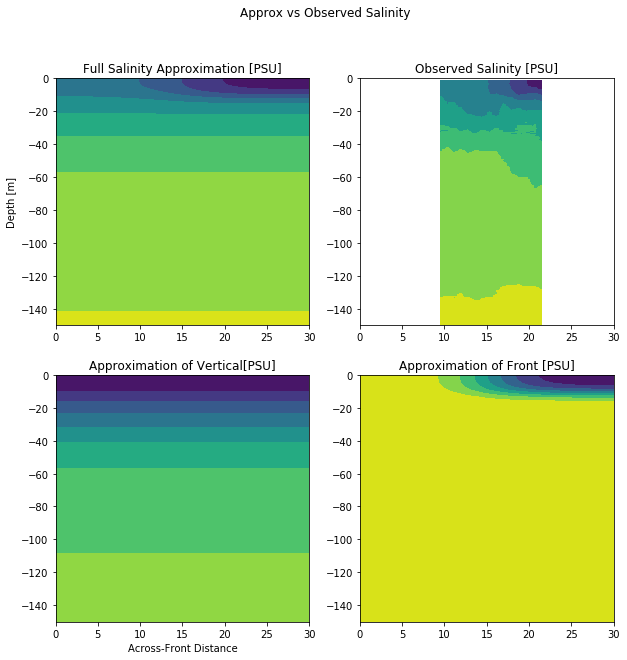

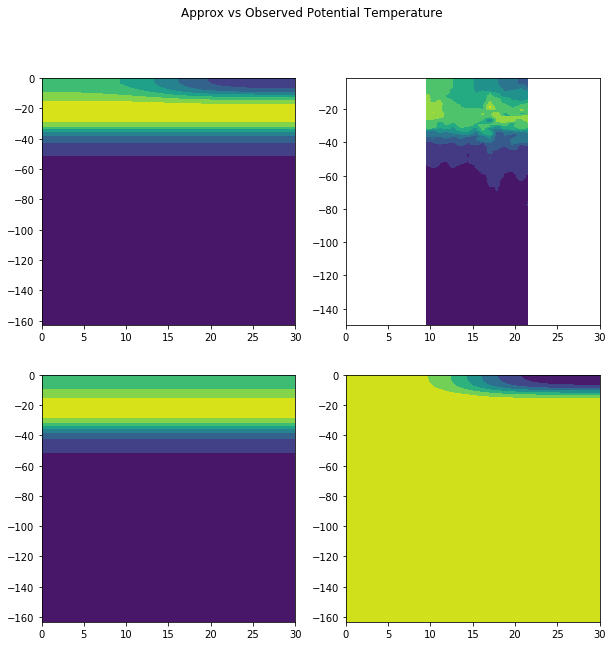

In [11]:
# Absolute Salinity
# Get contouf levels

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1,xlim=(0,L['y']),ylim=(-L['z'],0))
ax2 = fig.add_subplot(2,2,2,xlim=(0,L['y']),ylim=(-L['z'],0))
ax3 = fig.add_subplot(2,2,3,xlim=(0,L['y']),ylim=(-L['z'],0))
ax4 = fig.add_subplot(2,2,4,xlim=(0,L['y']),ylim=(-L['z'],0))
fig.suptitle('Approx vs Observed Salinity')
# Full approximation
ax1.contourf(y['G'],z['G'],S['S_yGzG'])
ax1.title.set_text('Full Salinity Approximation [PSU]')
ax1.set_ylabel('Depth [m]')
# Observed Salinity
ax2.contourf(ds['y']+y['G'][-1]/2-ds['y'][-1]/2,ds['z'],ds['S'])
ax2.title.set_text('Observed Salinity [PSU]')
# Vertical only
ax3.contourf(y['G'],z['G'],S['vertonly_yGzG'])
ax3.title.set_text('Approximation of Vertical[PSU]')
ax3.set_xlabel('Across-Front Distance')
# Front only
ax4.contourf(y['G'],z['G'],S['frontonly_yGzG'])
ax4.title.set_text('Approximation of Front [PSU]')
plt.show()


# Conservative Temperature
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1,xlim=(0,L['y']))
ax2 = fig.add_subplot(2,2,2, sharex=ax1)
ax3 = fig.add_subplot(2,2,3, sharex=ax1)
ax4 = fig.add_subplot(2,2,4, sharex=ax1)
fig.suptitle('Approx vs Observed Potential Temperature')
# Full approximation
ax1.contourf(y['G'],z['G'],T['PT_yGzG'])

# Observed Temperature
ax2.contourf(ds['y']+y['G'][-1]/2-ds['y'][-1]/2,ds['z'],ds['PT'])

# Vertical only
ax3.contourf(y['G'],z['G'],T['vertonly_yGzG'])

# Front only
ax4.contourf(y['G'],z['G'],T['frontonly_yGzG'])

plt.show()

## Test density for static stability
Use the MDJWF EOS

In [12]:
# Convert pressure vectors into arrays
P_yCzC = gsw.p_from_z(np.tile(z['C'].reshape(-1,1),(1,N['y'])),lat_4f)
P_yCzG = gsw.p_from_z(np.tile(z['G'].reshape(-1,1),(1,N['y'])),lat_4f)
P_yGzC = gsw.p_from_z(np.tile(z['C'].reshape(-1,1),(1,N['y']+1)),lat_4f)
P_yGzG = gsw.p_from_z(np.tile(z['G'].reshape(-1,1),(1,N['y']+1)),lat_4f)

# Calc potential density referenced to the surface
rho0_yCzC = mdjwf.dens(S['S_yCzC'],T['PT_yCzC'],P_yCzC)
rho0_yCzG = mdjwf.dens(S['S_yCzG'],T['PT_yCzG'],P_yCzG)
rho0_yGzC = mdjwf.dens(S['S_yGzC'],T['PT_yGzC'],P_yGzC)
rho0_yGzG = mdjwf.dens(S['S_yGzG'],T['PT_yGzG'],P_yGzG)

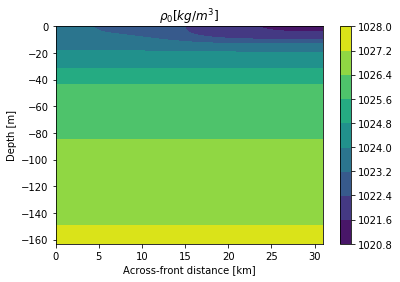

In [13]:
# Plot Denisty
plt.contourf(y['G'],z['G'],rho0_yGzG)
plt.colorbar()
plt.title('$\\rho_0 [kg/m^3]$')
plt.xlabel('Across-front distance [km]')
plt.ylabel('Depth [m]')
plt.show()

## Calculate Stratification to ensure static stability

In [14]:
# Define function to calculate N2
def Nsquarred(dens,z):
    # Get number of profiles
    Nz,Nprfs = dens.shape
    
    # Set constants
    g = -9.81
    
    # Calc drho and dz
    drho = np.diff(dens,axis=0)
    dz = np.tile(np.diff(z).reshape(-1,1),(1,Nprfs))
    
    # Get rho bar for each profile
    rho_bar = np.tile(np.mean(dens,axis=0).reshape(1,-1),(Nz-1,1))
    
    # Calc N2
    N2 = g*drho/(rho_bar*dz)
    
    # Calc z at midpoints
    z_N2 = z[:-1] + np.diff(z)/2
    
    return N2, z_N2;

In [15]:
N2, z['N2'] = Nsquarred(rho0_yGzG,z['G'])

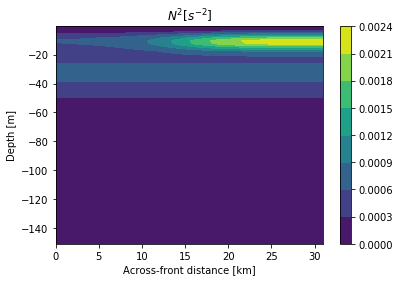

In [16]:
plt.contourf(y['G'],z['N2'],N2)
plt.colorbar()
plt.title('$N^2 [s^{-2}]$')
plt.xlabel('Across-front distance [km]')
plt.ylabel('Depth [m]')
plt.show()

In [17]:
# Estimate baroclinic mixed layer Rossby radius
# Get N_bar over H1
N_bar = np.sqrt(N2[-z['N2'] < H1].mean())
# Estimate R
R_ros = N_bar * H1/(f*1000)
print(R_ros)

1.9682986116965087


## Calculate geostrophic velocities and sea surface height
Geostrophic velocity:
$$U(y,z) = \frac{g}{f} \int_{-H}^z \frac{1}{\rho}\frac{\partial\rho}{\partial y}dz$$

Sea surface height:
$$\eta(y) = \frac{1}{\rho(y,0)} \int_{-H}^0 [\rho(y,z) - \frac{1}{2}[\rho(0,z)+\rho(L,z)]]dz $$

In [18]:
# Define function to calculate geostrophic velocity assuming zero flow at bottom
def geostrophic_velocity_zg(dens_yG,dens_yC,y,z,f):
    # Set constants
    g = 9.81
    
    # Get gradients and integrand
    drho = np.diff(dens_yG,axis=1)
    dy = 1000*np.tile(np.diff(y).reshape(1,-1),(z.size,1))
    inv_rho = 1/dens_yC
    INT = (g/f)*inv_rho*drho/dy
        
    # Solve integral
    INT_ud = np.flipud(INT)
    z_ud = np.flipud(z.reshape(-1,1))
    u_ud = integrate.cumtrapz(INT_ud,z_ud,axis=0)
    u_geo = np.flipud(u_ud)
    return u_geo;

In [19]:
# Define function to calculate geostrophic velocity assuming zero flow at bottom
def geostrophic_velocity_zc(dens_yG,dens_yC,y,z,f):
    # Set constants
    g = 9.81
    
    # Get gradients and integrand
    drho = np.diff(dens_yG,axis=1)
    dy = 1000*np.tile(np.diff(y).reshape(1,-1),(z.size,1))
    inv_rho = 1/dens_yC
    INT = (g/f)*inv_rho*drho/dy
        
    # Solve integral
    INT_ud = np.flipud(INT)
    z_ud = np.flipud(z.reshape(-1,1))
    u_ud = integrate.cumtrapz(INT_ud,z_ud,axis=0,initial=0)
    u_geo = np.flipud(u_ud)
    return u_geo;

In [20]:
# Get u_geostrophic
u_geo = geostrophic_velocity_zc(rho0_yGzC,rho0_yCzC,y['G'],z['C'],f)
# Deal with numerical noise
u_geo[u_geo > 0] = 0

# Calculate sea surface height
# Isolate density at the surface
rho_0_inv = 1/rho0_yCzG[0,:]
# Get mean density as a function of depth
rho_ybar = np.tile(((rho0_yCzG[:,0]+rho0_yCzG[:,-1])/2).reshape(-1,1),(1,N['y']))
# Inegrate density for eta
eta = rho_0_inv * np.trapz(rho0_yCzG - rho_ybar,z['G'],axis=0)

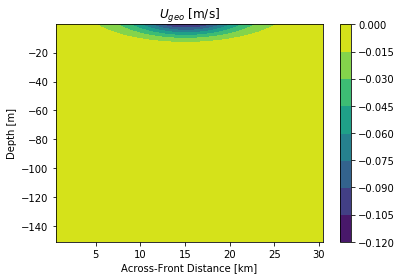

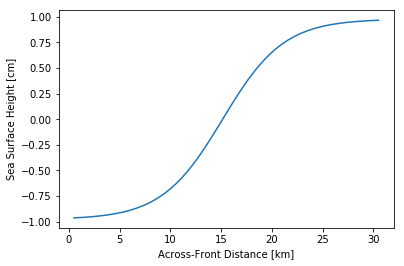

In [21]:
# Plot
plt.contourf(y['C'],z['C'],u_geo)
plt.colorbar()
plt.ylabel('Depth [m]')
plt.xlabel('Across-Front Distance [km]')
plt.title('$U_{geo}$ [m/s]')
plt.show()

plt.plot(y['C'],eta*100)
plt.xlabel('Across-Front Distance [km]')
plt.ylabel('Sea Surface Height [cm]')
plt.show()

## Calculate required viscosity and timestep

In [22]:
# Required grid scale viscosity [m2/s]
nu_min = (1000*L['x']/N['x']) * abs(u_geo)
print('Required minimum viscosity: %.3E [m^2/s]' %nu_min.max())

# Required time step
dt = (1000*L['x']/N['x']) / abs(u_geo).max()
print('Minimum timestep: %i [sec]' %dt)

# Numerical Stability for inertial oscillations
Si = f*dt
print('S_i = %.2f, should be < 0.5 for stability' %Si)

Required minimum viscosity: 1.145E+02 [m^2/s]
Minimum timestep: 8730 [sec]
S_i = 1.21, should be < 0.5 for stability


## Add along-front dimension to data

In [23]:
# Add x-dimesion to data and reshape to be (z,y,x) for 3D and (y,x) for surface fields
# Temperature
pt = copy(T['PT_yCzC'].reshape(N['z'],N['y'],1))
# Replicate into 3-D
pt = np.tile(pt,(1,1,N['x']))

# Salinity
SP = copy(S['S_yCzC'].reshape(N['z'],N['y'],1))
# Replicate into 3-D
SP = np.tile(SP,(1,1,N['x']))

# Velocity
UU = copy(u_geo.reshape(N['z'],N['y'],1))
# Set walls to zero
UU[:,0] = 0
UU[:,-1] = 0
# Replicate into 3-D
UU = np.tile(UU,(1,1,N['x']))

# Eta
Eta = copy(eta.T)
Eta[0] = 0
Eta[-1] = 0
Eta = np.tile(Eta.reshape(N['y'],1),(1,N['x']))

## Add Random Noise to Salinity

In [24]:
# STD of noise is dS/100
Stest = 20
while abs(Stest) > 1:
    Snoise = np.random.normal(0,-dS/1000,(N['z'],N['y'],N['x']))
    Stest = np.sum(Snoise)

print('The mean salinity noise is {:.3E} PSU'.format(np.mean(Snoise)))
print('The sum of the salinity noist is {0:.2f} PSU'.format(np.sum(Snoise)))

The mean salinity noise is 3.910E-06 PSU
The sum of the salinity noist is 0.00 PSU


In [25]:
# Add noise to Salinity
SP_noisy = SP + Snoise

## Summary of inputs as final check

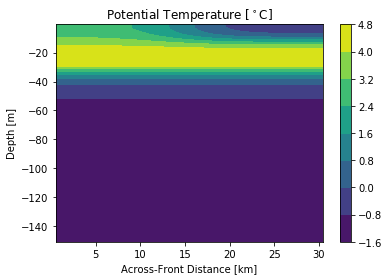

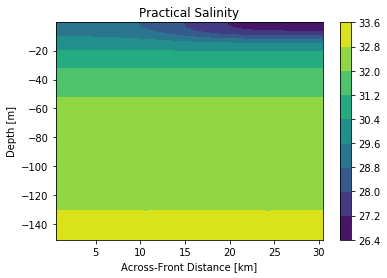

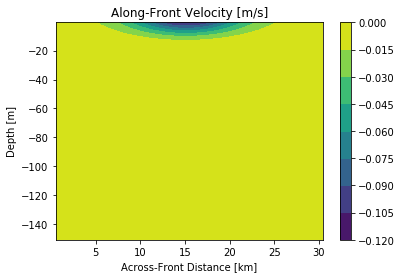

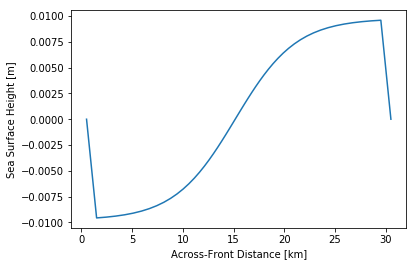

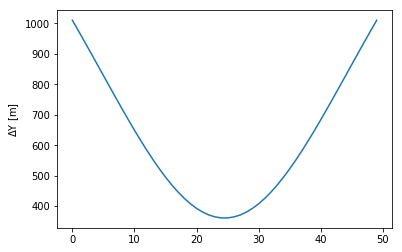

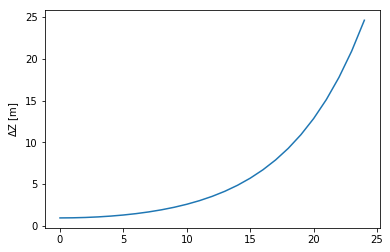

In [26]:
# Plot slices to check that its still good data
# Temperature
plt.contourf(y['C'],z['C'],pt[:,:,0])
plt.xlabel('Across-Front Distance [km]')
plt.ylabel('Depth [m]')
plt.title('Potential Temperature [$^\circ$C]')
plt.colorbar()
plt.show()

# Salinity
plt.contourf(y['C'],z['C'],SP_noisy[:,:,0])
plt.xlabel('Across-Front Distance [km]')
plt.ylabel('Depth [m]')
plt.title('Practical Salinity')
plt.colorbar()
plt.show()

# Velocity
plt.contourf(y['C'],z['C'],UU[:,:,0])
plt.xlabel('Across-Front Distance [km]')
plt.ylabel('Depth [m]')
plt.title('Along-Front Velocity [m/s]')
plt.colorbar()
plt.show()

# Eta
if N['x'] > 1:
    plt.contourf(x['C'],y['C'],Eta)
    plt.ylabel('Across-Front Distance [km]')
    plt.xlabel('Along-Front Distance [km]')
    plt.title('Sea Surface Height [m]')
    plt.colorbar()
    plt.show()
else:
    plt.plot(y['C'],Eta)
    plt.xlabel('Across-Front Distance [km]')
    plt.ylabel('Sea Surface Height [m]')
    plt.show()

# delY
plt.plot(delY)
plt.ylabel('$\Delta$Y [m]')
plt.show()

# delZ
plt.plot(delZ)
plt.ylabel('$\Delta$Z [m]')
plt.show()

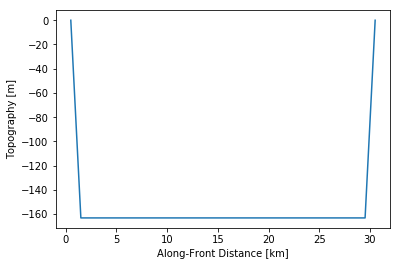

In [27]:
# Make bottom topography
z_bot = z['G'][-1] * np.ones((N['y'],N['x']))
# Make southern and northern walls
z_bot[0,:] = 0
z_bot[-1,:] = 0

# Plot
if N['x'] > 1:
    plt.contourf(x['C'],y['C'],z_bot)
    plt.xlabel('Along-Front Distance [km]')
    plt.ylabel('Across-Front Distance [km]')
    plt.title('Topography [m]')
    plt.colorbar()
    plt.show()
else:
    plt.plot(y['C'],z_bot)
    plt.xlabel('Along-Front Distance [km]')
    plt.ylabel('Topography [m]')
    plt.show()
    

## Write variables to binary files

In [28]:
# Write approximated observations to binary files
# Make directory for set up
dataout = datapath + 'gcm_input/Lx%03dLy%03dLz%03d_Nx%03dNy%03dNz%03d/' % \
(L['x'], L['y'], L['z'], N['x'], N['y'], N['z'])
os.mkdir(dataout)

# delY
delY.astype(tp).tofile(dataout + 'dy.bin')

# delZ
delZ.astype(tp).tofile(dataout + 'dz.bin')

# Topo
z_bot.astype(tp).tofile(dataout + 'topog.bin')

# Temperature
pt.astype(tp).tofile(dataout + 'theta.bin')

# Salinity
SP.astype(tp).tofile(dataout + 'salt.bin')
SP_noisy.astype(tp).tofile(dataout + 'salt_noisy.bin')

# Velocity
UU.astype(tp).tofile(dataout + 'uvel.bin')

# SSH
Eta.astype(tp).tofile(dataout + 'eta.bin')